In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from models import MRIResNetClassifier
from multiprocessing import cpu_count

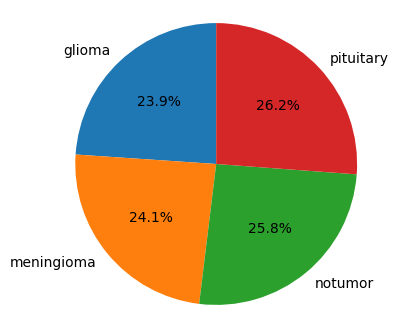

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_data = datasets.ImageFolder(root="cleaned/Training", transform=transform)
class_names = train_data.classes

train_counts = Counter(train_data.targets)
counts = [train_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

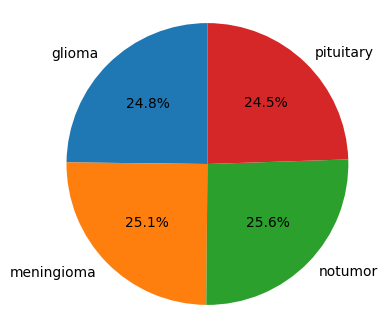

In [4]:
test_data = datasets.ImageFolder(root="cleaned/Testing", transform=transform)

test_counts = Counter(test_data.targets)
counts = [test_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [5]:
res = {}
for i, class_name in enumerate(class_names):
    train_count = train_counts[i]
    test_count = test_counts[i]
    total_count = train_count + test_count
    train_percentage = (train_count / total_count) * 100 if total_count > 0 else 0
    test_percentage = (test_count / total_count) * 100 if total_count > 0 else 0
    res[class_name] = {
        "train_count": train_count,
        "test_count": test_count,
        "train_percentage": train_percentage,
        "test_percentage": test_percentage
    }

print("Train-test split per class:")
for class_name, stats in res.items():
    print(f"{class_name}: Train = {stats['train_count']} ({stats['train_percentage']:.2f}%), "
          f"Test = {stats['test_count']} ({stats['test_percentage']:.2f}%)")

Train-test split per class:
glioma: Train = 1321 (81.54%), Test = 299 (18.46%)
meningioma: Train = 1333 (81.53%), Test = 302 (18.47%)
notumor: Train = 1422 (82.15%), Test = 309 (17.85%)
pituitary: Train = 1445 (83.05%), Test = 295 (16.95%)


In [6]:
num_workers = cpu_count() // 2

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)

In [7]:
def train(model, epochs, loader, optimizer, criterion, device):
    for epoch in range(epochs):
        total_train_loss = 0.0
        train_pred_correct = 0
        total = 0
        model.train()
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            pred_labels = outputs.argmax(dim=1)
            train_pred_correct += pred_labels.eq(labels).sum().item()
            total += len(labels)
            total_train_loss += loss

            loss.backward()
            optimizer.step()

        print("Epoch " + str(epoch+1) + ": loss=" + str(total_train_loss.item()/len(loader)) + ", accuracy=" + str(train_pred_correct/total))
                

def evaluate(model, loader, criterion, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            pred_labels = outputs.argmax(dim=1)

            all_labels = np.concatenate((all_labels, labels.int().detach().cpu().numpy()))
            all_predictions = np.concatenate((all_predictions, pred_labels.int().detach().cpu().numpy()))

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="macro")

    print("Confusion matrix:\n{}".format(conf_matrix))
    print('Accuracy: {}'.format(acc))
    print('F1 score: {}'.format(f1)) 
    
    return acc, f1
                

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = MRIResNetClassifier(len(train_data.classes))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, 5, train_loader, optimizer, criterion, device)

print('Test evaluation:')
evaluate(model, test_loader, criterion, device)
print('\n')

Epoch 1: loss=1.3439597421987897, accuracy=0.39050896576707117


In [ ]:
# TODO:
# -> treba dodati val data i optimizaciju parametara